In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision

from torch.utils.data import Dataset, random_split, DataLoader
import os

from cnn_class import cnn_architecture
from tifffile import imread
import numpy as np
import matplotlib.pyplot as plt

kelp img shape (350, 350, 7)
NDVI =  -0.07615425966211388
max =  23244
rgb_img_plot shape =  (350, 350, 3)


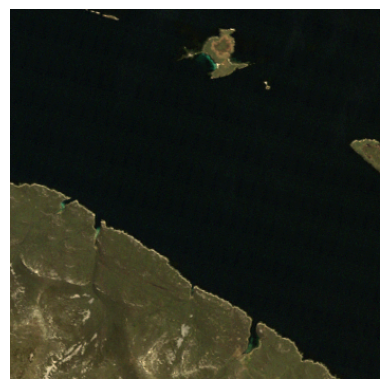

In [68]:
from sklearn.preprocessing import minmax_scale

path ='/Users/nadira/gatech/Sp24/CV/kelp_segmentation/data/train_satellite/AA498489_satellite.tif'

img = imread(path)
# Check the shape
print('kelp img shape', img.shape)
rgb_img = np.array(img)
temp1 = rgb_img[:, :, 2]-rgb_img[:, :, 1]
temp2 = rgb_img[:, :, 2]+rgb_img[:, :, 1]
diff = temp1/temp2
# get average of the NDVI
print('NDVI = ', np.mean(diff))

print('max = ', np.max(rgb_img))

# Normalize the image array
rgb_img_plot = rgb_img[:, :, 2:5]
# Scale RGB image for train_data
rgb_img_plot = minmax_scale(rgb_img_plot.ravel(), feature_range=(0,255)).reshape(rgb_img_plot.shape)

# Show RGB image for train_data
rgb_img_plot = rgb_img_plot / np.max(rgb_img_plot)
print("rgb_img_plot shape = ", rgb_img_plot.shape)
plt.figure()
plt.imshow(rgb_img_plot)
plt.axis('off')
plt.show()

kelp img shape (350, 350)
max =  1


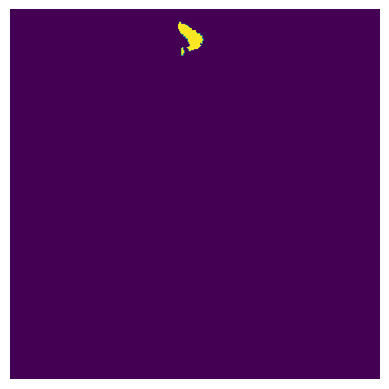

In [69]:
path ='/Users/nadira/gatech/Sp24/CV/kelp_segmentation/data/train_kelp/AA498489_kelp.tif'

img = imread(path)
# Check the shape
print('kelp img shape', img.shape)
rgb_img = np.array(img)

print('max = ', np.max(rgb_img))

# Normalize the image array
rgb_img_plot = rgb_img/ np.max(rgb_img)
plt.figure()
plt.imshow(rgb_img_plot)
plt.axis('off')
plt.show()

In [70]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None, target_transform=None):
        self.img_labels = label_dir
        self.img_dir = img_dir
        # self.transform = transform
        # self.target_transform = target_transform

    def __len__(self):
        lst = os.listdir(self.img_dir)
        number_img = len(lst)
        return number_img

    def __getitem__(self, idx):
        # read img from folder in order of idx using os.listdir
        img_path = os.path.join(self.img_dir, sorted(os.listdir(self.img_dir))[idx])
        # read image
        image = imread(img_path)
        img_array = np.array(image)
        # get the rgb image
        rgb_img, _ = np.split(img_array, [3], axis=2)
        rgb_img = rgb_img.transpose(2, 0, 1)
        # print('rgb_img shape:', rgb_img.shape)
        image = torch.tensor(rgb_img) / 255.0

        # get the label
        label_path = os.path.join(self.img_labels, sorted(os.listdir(self.img_labels))[idx])
        label = imread(label_path)
        label = np.array(label)
        # print('label shape:', label.shape)

        label = torch.tensor(label)
        label = label.float()
        # label = label.flatten()
        # print('label:', label.shape)
        # image 3*350*350 ; label: 350*350
        return image.float(), label


In [71]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = cnn_architecture().to(device)
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

# Perform training loop for n epochs
loss_list = []
n_epochs = 10
loss_fn = nn.MSELoss()

In [72]:
def train_model(model, dataloader, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    test_loss = 0.
    total_correct = 0
    total_samples = 0
    for batch, (images, targets) in enumerate(dataloader):
        # print(targets.shape)

        images = images.to(device)
        targets = targets.to(device)
        targets = targets.squeeze(0)

        optimizer.zero_grad()
        output = model(images)
        output = output.reshape(-1, 350, 350)
        _, predicted = torch.max(output.data, 0)
        # print(output.shape)
        loss = loss_fn(targets.float(), predicted.float())
        # print(loss.item())
        test_loss += loss.item()

        total_samples += targets.size(0)
        total_correct += (predicted == targets).sum().item()

    accuracy = 100 * total_correct / total_samples
    test_loss /= len(dataloader)

In [73]:
def test_model(model, dataloader, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0.
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            targets = targets.to(device)
            targets = targets.squeeze(0)

            pred = model(images)
            pred = pred.reshape(-1, 350, 350)
            # get the output with the highest accuracy
            _, predicted = torch.max(pred.data, 0)
            # determine the loss
            loss = loss_fn(targets.float(), predicted.float())
            test_loss += loss.item()

            # Update the running total of correct predictions and samples
            total_correct += (predicted == targets).sum().item()
            total_samples += targets.size(0)

        # Calculate the accuracy for this epoch
    accuracy = 100 * total_correct / total_samples

    test_loss /= num_batches
    return test_loss, accuracy

In [74]:
# Load the datset (split into train and test)
collected_data = CustomImageDataset('/Users/nadira/gatech/Sp24/CV/kelp_segmentation/data/train_satellite', '/Users/nadira/gatech/Sp24/CV/kelp_segmentation/data/train_kelp')

size = len(collected_data)
train_size = int(0.8 * size)
test_size = size - train_size

train_data, test_data = random_split(collected_data, [train_size, test_size])

# Start training
train_data_len = len(train_data)
test_data_len = len(test_data)

train_dataloader = DataLoader(train_data, shuffle=True)
test_dataloader = DataLoader(test_data, shuffle=True)
epochs = 10
test_loss = []
train_loss = []


In [75]:
for t in range(n_epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_l, accuracy = train_model(model, train_dataloader, loss_fn, optimizer)
    test_l, test_accuracy = test_model(model, test_dataloader, loss_fn)
    test_loss.append(test_l)
    train_loss.append(train_l)

    print(f"\nTest Error: \n----------\n{test_l:.6f}")
    print(f"\nTrain Error: \n----------\n{train_l:.6f}")
    print(f'Epoch {t + 1}: training Accuracy = {accuracy:.2f}%; test Accuracy = {test_accuracy:.2f}%')



Epoch 1
-------------------------------


KeyboardInterrupt: 

In [ ]:

# Save model
save_path = 'first_model.pth'
torch.save(model.state_dict(), save_path)